In [18]:
import torch
import numpy as np
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import os

In [19]:
train_dataset_path = r'C:\Users\AdmPDI\Desktop\will\pytorchproject\studysession\data\train'
test_dataset_path = r'C:\Users\AdmPDI\Desktop\will\pytorchproject\studysession\data\test'

In [20]:
batch_size = 32
mean=(0.5,0.5,0.5)
std=(0.5,0.5,0.5)

transform = transforms.Compose([
     transforms.Resize(254),
     transforms.RandomRotation(degrees=30),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
     transforms.ToTensor(),
     transforms.Normalize(mean, std)
     ])



train_data = torchvision.datasets.ImageFolder(root=train_dataset_path, transform=transform)

test_data = torchvision.datasets.ImageFolder(root=test_dataset_path, transform=transform)


In [21]:
(len(train_data)), (len(test_data))

(2296, 225)

In [22]:
# Prepare dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32)
categorias = ["aro", "cubo", "raio"]

In [23]:
len(train_loader), len(test_loader)

(72, 8)

cubo  raio  aro  cubo  cubo  aro  aro  raio  aro  cubo  raio  raio  raio  raio  cubo  cubo  cubo  raio  aro  aro  cubo  aro  aro  raio  aro  cubo  cubo  aro  aro  cubo  raio  raio


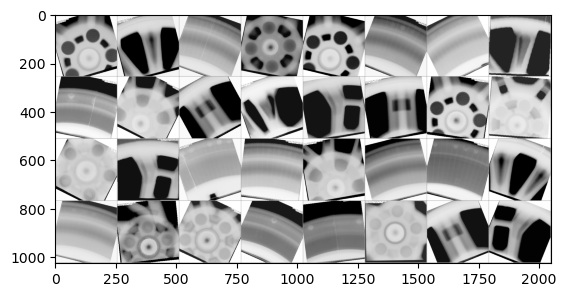

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(train_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(categorias[labels[j]] for j in range(32)))

In [25]:
import torch.nn as nn
import torch.nn.functional as F

class ConvolutionalModel(nn.Module):
  def __init__(self):
      super().__init__()
      self.convlayers = nn.Sequential(
        nn.Conv2d(3, 16, 4),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(16, 32, 4),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),       
      )
 
      self.linearlayers = nn.Sequential(
          nn.Linear(119072, 128),
          nn.ReLU(),
          nn.Linear(128, 3),
          ) 
 
  def forward(self, x):
      x = self.convlayers(x)
      x = torch.flatten(x, 1)
      return self.linearlayers(x)
  


In [26]:
#model = ConvolutionalModel()
#input = torch.rand([4, 3, 256, 256]) # [batch size, channels, height, width]
#print(f"Input shape: {input.shape}")
#output = model.forward(input)
#print(f"Output shape: {output.shape}")


In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Rodando na {device}")

Rodando na cuda


In [28]:
model = ConvolutionalModel().to(device)

In [29]:
model.eval()

ConvolutionalModel(
  (convlayers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linearlayers): Sequential(
    (0): Linear(in_features=119072, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=3, bias=True)
  )
)

In [30]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [31]:
def train(model, dataloader, loss_func, optimizer):
  model.train()
  cumloss = 0.0

  for imgs, labels in dataloader:
    imgs, labels = imgs.to(device), labels.to(device)
    
    optimizer.zero_grad()

    pred = model(imgs)

    loss = loss_func(pred, labels)
    loss.backward()
    optimizer.step()

    cumloss += loss.item()

  return cumloss / len(dataloader)

def validate(model, dataloader, loss_func):
  model.eval()
  cumloss = 0.0

  with torch.no_grad():
    for imgs, labels in dataloader:
      imgs, labels = imgs.to(device), labels.to(device)

      pred = model(imgs)
      loss = loss_func(pred, labels)
      cumloss += loss.item()

  return cumloss / len(dataloader)

In [32]:
len(train_loader)

72

In [33]:
def plot_losses(losses):
  fig = plt.figure(figsize=(13, 5))
  ax = fig.gca()
  for loss_name, loss_values in losses.items():  
    ax.plot(loss_values, label=loss_name)
  ax.legend(fontsize="16")
  ax.set_xlabel("Iteration", fontsize="16")
  ax.set_ylabel("Loss", fontsize="16")
  ax.set_title("Loss vs iterations", fontsize="16");

In [34]:
epochs = 10
train_losses = []
test_losses = []
for t in range(epochs):
  train_loss = train(model, train_loader, loss_func, optimizer)
  train_losses.append(train_loss)

  test_loss = validate(model, test_loader, loss_func)
  test_losses.append(test_loss)

  if t % 2 == 0:
    print(f"Epoch [{t+1}/{epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {test_loss:.4f}")

Epoch [1/10], Train Loss: 0.8564, Validation Loss: 0.5763
Epoch [3/10], Train Loss: 0.2037, Validation Loss: 0.1321
Epoch [5/10], Train Loss: 0.0847, Validation Loss: 0.0747
Epoch [7/10], Train Loss: 0.0587, Validation Loss: 0.0324
Epoch [9/10], Train Loss: 0.0488, Validation Loss: 0.0221


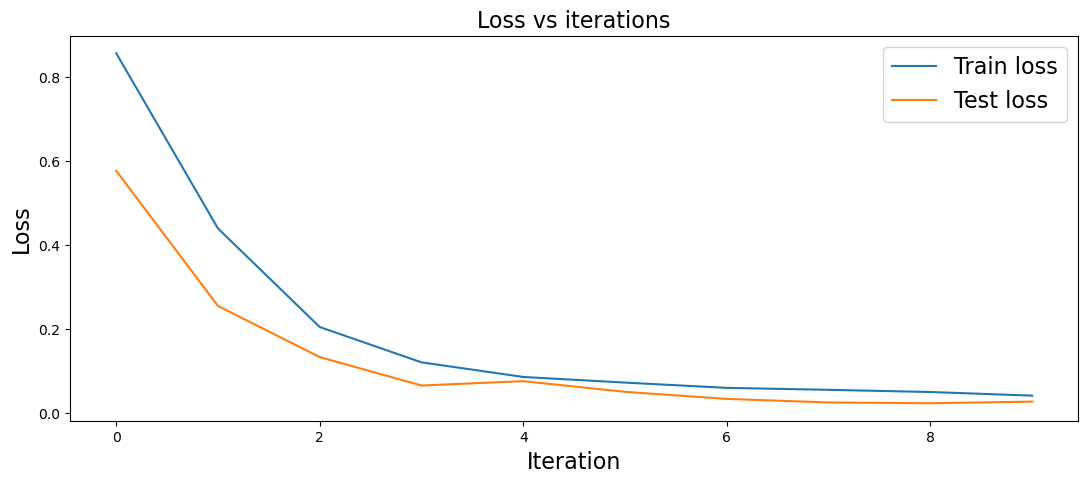

In [35]:
losses = {"Train loss": train_losses, "Test loss": test_losses}
plot_losses(losses)

In [36]:
def make_confusion_matrix(model, loader, n_classes):
  confusion_matrix = torch.zeros(n_classes, n_classes, dtype=torch.int64)
  with torch.no_grad():
    for i, (imgs, labels) in enumerate(loader):
      imgs = imgs.to(device)
      labels = labels.to(device)
      outputs = model(imgs)
      _, predicted = torch.max(outputs, 1)
      for t, p in zip(torch.as_tensor(labels, dtype=torch.int64).view(-1), 
                      torch.as_tensor(predicted, dtype=torch.int64).view(-1)):
        confusion_matrix[t, p] += 1
  return confusion_matrix

def evaluate_accuracy(model, dataloader, classes, verbose=True):
  # prepare to count predictions for each class
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  confusion_matrix = make_confusion_matrix(model, dataloader, len(classes))
  if verbose:
    total_correct = 0.0
    total_prediction = 0.0
    for i, classname in enumerate(classes):
      correct_count = confusion_matrix[i][i].item()
      class_pred = torch.sum(confusion_matrix[i]).item()

      total_correct += correct_count
      total_prediction += class_pred

      accuracy = 100 * float(correct_count) / class_pred
      print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                    accuracy))
  print("Global acccuracy is {:.1f}".format(100 * total_correct/total_prediction))
  return confusion_matrix

def test(model, dataloader, classes):
  # prepare to count predictions for each class
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  # again no gradients needed
  with torch.no_grad():
      for images, labels in dataloader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predictions = torch.max(outputs, 1)
          # collect the correct predictions for each class
          for label, prediction in zip(labels, predictions):
              if label == prediction:
                  correct_pred[classes[label]] += 1
              total_pred[classes[label]] += 1

  # print accuracy for each class
  total_correct = 0.0
  total_prediction = 0.0
  for classname, correct_count in correct_pred.items():
      total_correct += correct_count
      total_prediction += total_pred[classname]
      accuracy = 100 * float(correct_count) / total_pred[classname]
      print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                    accuracy))
  print("Global acccuracy is {:.1f}".format(100 * total_correct/total_prediction))


In [37]:
confusion_matrix = evaluate_accuracy(model, test_loader, categorias)

Accuracy for class aro   is: 100.0 %
Accuracy for class cubo  is: 100.0 %
Accuracy for class raio  is: 100.0 %
Global acccuracy is 100.0


In [41]:
import seaborn as sn

<AxesSubplot:>

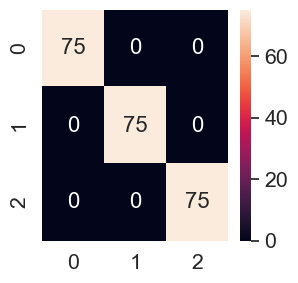

In [43]:
plt.figure(figsize=(3, 3))
sn.set(font_scale=1.4)
sn.heatmap(confusion_matrix.tolist(), 
           annot=True, annot_kws={"size": 16}, fmt='d')